# Requirements

In [1]:
pip install transformers datasets tqdm konlpy googletrans==4.0.0-rc1 diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 7.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17414 sha256=620838c5642cf8b707b517857030f2315f1703cb8a802441fd654f4d183b243e
  Stored in directory: /root/.cache/pip/wheels/a9/25/af/715361fa79594524c89c75d293def652045f3fdce6ca398712
Successfully built googletra

# Model Set

In [2]:
from urllib import request
import requests
from bs4 import BeautifulSoup 
from urllib.request import urlopen, urlretrieve
from urllib.parse import quote_plus # 한글 처리용 함수
import pandas as pd
import numpy as np
import time
import os
from konlpy.tag import Okt
from googletrans import Translator
from diffusers import StableDiffusionPipeline
from gensim.summarization.summarizer import summarize
import torch
import nltk


In [3]:
model_id = "prompthero/openjourney"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
translator = Translator()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [4]:
nltk.download('punkt')
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

t5_model = AutoModelForSeq2SeqLM.from_pretrained('eenzeenee/t5-small-korean-summarization')
t5_tokenizer = AutoTokenizer.from_pretrained('eenzeenee/t5-small-korean-summarization')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
from transformers import AutoModel, AutoTokenizer

klue_bert_base_model = AutoModel.from_pretrained("klue/bert-base")
klue_bert_base_tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# unmasker

In [9]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='klue/bert-base')
unmasker("손흥민은 [MASK] 선수 입니다")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.3288685381412506,
  'token': 4713,
  'token_str': '축구',
  'sequence': '손흥민은 축구 선수 입니다'},
 {'score': 0.043872810900211334,
  'token': 5873,
  'token_str': '엄청난',
  'sequence': '손흥민은 엄청난 선수 입니다'},
 {'score': 0.040990594774484634,
  'token': 11251,
  'token_str': '손흥민',
  'sequence': '손흥민은 손흥민 선수 입니다'},
 {'score': 0.033716849982738495,
  'token': 20482,
  'token_str': '토트넘',
  'sequence': '손흥민은 토트넘 선수 입니다'},
 {'score': 0.030918965116143227,
  'token': 4407,
  'token_str': '독일',
  'sequence': '손흥민은 독일 선수 입니다'}]

# 뉴스에서 본문 받아오기

In [31]:
# 다음 뉴스 본문 뽑기
url= 'https://news.daum.net/'
url = 'https://news.daum.net/society#1'
header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}

documents = []

html_page = requests.get(url, header)
soup = BeautifulSoup(html_page.text, 'lxml') 
document = soup.select(".link_txt")  # select_one 는 한개만 받아옴

for t in document:
  link = t.attrs['href']
  if link[:20] == 'https://v.daum.net/v' : # 다음 뉴스 링크만 가져오기
    sub_text = ''
    sub_html = requests.get(link, header)
    sub_soup = BeautifulSoup(sub_html.text, 'lxml')
    contents = sub_soup.select('div.news_view.fs_type1 > div.article_view > section > p')[:-1]
    for p in contents:
      sub_text+=(p.text)
    documents.append(sub_text)

In [32]:
len(documents)  # 크롤링 한 뉴스 갯수

25

In [33]:
documents[np.random.randint(len(documents))]  # 랜덤하게 아무거나 뽑아보기

"[앵커] 전남 신안 앞바다 어선 전복 사고로 실종된 선원들이 속속 발견되고 있지만, 안타깝게도 생환 소식은 없습니다. 실종자 가족이 머무는 대기실도 침통한 분위기가 이어지고 있습니다. 김민성 기자가 보도합니다. [기자] 실종자 9명 가운데 맨 처음 수습된 선원은 기관장 김 모 씨입니다. 아들 결혼자금을 마련하겠다며 뱃일을 계속했다던 성실한 가장. 새벽에 의식과 호흡 없이 선원 침실 입구에서 발견돼 끝내 사망 판정을 받았습니다. [김해철 / 전남 목포해양경찰서장 : 사고 선박 통발 어구 등 장애물을 제거하는 과정에서 선내 선원 침실 입구 우현 쪽에서 이불, 그물, 로프 등 사이에….] 많게는 수십 년도 뱃일을 한 베테랑인데, 가족들로선 현실을 받아들이기 쉽지 않습니다. 추가로 발견된 실종자들도 모두 숨진 상황이어서 신안군 수협 대기실은 적막감만 맴돌았습니다. [선장 가족 : 최대한 빨리 찾아주시면 하는 바람이고요. 뭐 있겠습니까. 다 똑같은 마음일 거 같아요.] 점심 무렵 선실에서 실종자 2명이 더 발견된 뒤 가족들은 수색 현장을 직접 지켜보기 위해 경비정을 타고 사고 해역으로 향했습니다. 해경은 선체 인양이 끝나면 열흘 정도 해상 수색을 더 이어갈 방침입니다. 실종자 가족들은 아직 희망의 끈을 놓지 못한 채 이를 수용할지를 여전히 고민 중입니다. YTN 김민성입니다. YTN 김민성 (kimms0708@ytn.co.kr)※ '당신의 제보가 뉴스가 됩니다' [카카오톡] YTN 검색해 채널 추가 [전화] 02-398-8585 [메일] social@ytn.co.kr"

# 기사 요약하기

In [34]:
prefix = "summarize: "
sample = documents[np.random.randint(len(documents))]

inputs = [prefix + sample]

inputs = t5_tokenizer(inputs, max_length=2000, truncation=True, return_tensors="pt")
output = t5_model.generate(**inputs, num_beams=3, do_sample=True, min_length=10, max_length=100)
decoded_output = t5_tokenizer.batch_decode(output, skip_special_tokens=True)[0]
summarized = nltk.sent_tokenize(decoded_output.strip())[0]
print(sample)
print(summarized)

[악천후 풍랑 속 선원 구하고 보니…]미국 서부 오레곤 주의 해안입니다.높은 파도와 강풍 속에, 현지 시간으로 지난 3일 오전 흰색 선박이 구조를 요청했습니다.[지난 3일 오전 미 서부 오레곤 주 해안서 선박 구조 요청]해안경비대는 위치를 파악해 출동했고, 마침 근처에서 구조 훈련중이던 훈련생도 이 구조요청을 듣고 헤엄쳐 선박에 접근했습니다.구조요원이 조난 선박에 가까이 다가간 바로 그 때, 높이 6미터가 넘는 큰 파도가 몰아치면서 선박은 파도에 휩쓸려 뒤집히고 맙니다. 넘는 파도에 조난 선박 뒤집혀..선원은 구조]화면엔 잡히지 않았지만 이 훈련생은 선원을 무사히 구조했고 두 사람 모두 해안경비대 헬리콥터가 케이블로 끌어올렸습니다.구조된 선원은 곧바로 병원으로 옮겨져 치료를 받고 퇴원할 수 있었는데요,[선원이 배를 훔쳐 달아나려다 악천후에 조난 당해]현지 경찰은 선원이 배를 훔쳐 달아나려다 악천후에 조난된 것으로 보고 조사를 벌이고 있습니다.sbs 조지현입니다.( 취재 : 조지현 / 영상편집 : 이승희 / 영상 출처 : 미국 해안경비대 트위터 / 제작 : D뉴스플랫폼부 )
미국 서부 오레곤 주의 해안에서 검은색 선박이 구조를 요청했고 인근에서 구조 훈련중이던 훈련생도 이 구조요청을 듣고 헤엄쳐 선박에 접근했다.


# 불용어 제거

In [35]:
f = open('korean_stopwords.txt', 'r')  
stopwords = f.read()   
stop_words = set(stopwords.split('\n'))

okt = Okt()

sentence = summarized
print(sentence)  # 원래 문장 출력
word_tokens = okt.morphs(sentence)

stop_words_result = [word for word in word_tokens if not word in stop_words]

sentence =''
for i in range(len(stop_words_result)):
  sentence += (" " + stop_words_result[i])

print(sentence) # 불용어 제거한 문장 출력

미국 서부 오레곤 주의 해안에서 검은색 선박이 구조를 요청했고 인근에서 구조 훈련중이던 훈련생도 이 구조요청을 듣고 헤엄쳐 선박에 접근했다.
 미국 서부 오레곤 주의 해안 검은색 선박 구조 요청 했고 인근 구조 훈련 중 이던 훈련 생도 조 요청 듣고 헤엄 쳐 선박 접근 했다 .


# Consine Similarity zero shot


In [36]:
from torch.nn import functional as F

labels = ["날씨", "정치", "경제", "세계", "스포츠", "생활문화", "IT과학", "사회"]


# run inputs through model and mean-pool over the sequence
# dimension to get sequence-level representations
inputs = klue_bert_base_tokenizer.batch_encode_plus([sentence] + labels,
                                     return_tensors='pt',
                                     pad_to_max_length=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
output = klue_bert_base_model(input_ids, attention_mask=attention_mask)[0]
sentence_rep = output[:1].mean(dim=1)
label_reps = output[1:].mean(dim=1)

# now find the labels with the highest cosine similarities to
# the sentence
similarities = F.cosine_similarity(sentence_rep, label_reps)
closest = similarities.argsort(descending=True)
print(sentence)
for ind in closest:
    print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')

 미국 서부 오레곤 주의 해안 검은색 선박 구조 요청 했고 인근 구조 훈련 중 이던 훈련 생도 조 요청 듣고 헤엄 쳐 선박 접근 했다 .
label: 사회 	 similarity: 0.3501111567020416
label: 세계 	 similarity: 0.33115309476852417
label: 스포츠 	 similarity: 0.32561156153678894
label: 경제 	 similarity: 0.3182133138179779
label: 생활문화 	 similarity: 0.30481377243995667
label: IT과학 	 similarity: 0.3032526671886444
label: 날씨 	 similarity: 0.2987871766090393
label: 정치 	 similarity: 0.287418395280838


# 번역 및 이미지 생성

  0%|          | 0/50 [00:00<?, ?it/s]

미국 서부 오레곤 주의 해안에서 검은색 선박이 구조를 요청했고 인근에서 구조 훈련중이던 훈련생도 이 구조요청을 듣고 헤엄쳐 선박에 접근했다.
Black vessels requested rescue from the coast of Western Oregon, and the trainees who were training nearby also heard this rescue request and approached the ship.


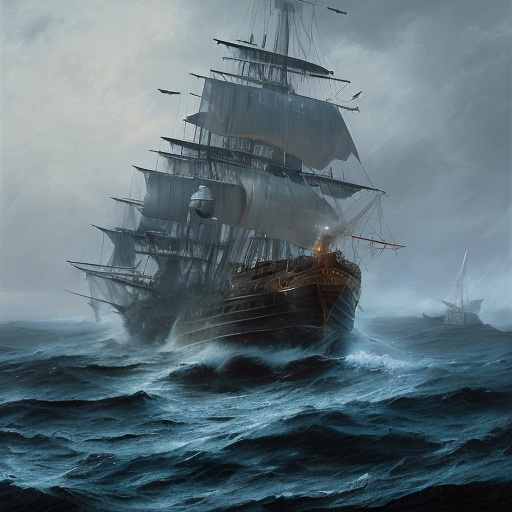

In [37]:
en_prompt = translator.translate(summarized, dest="en")
image = pipe(en_prompt.text+', mdjrny-v4 style').images[0]
print(summarized)
print(en_prompt.text)
image